In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/INTC_2015-01-01_2015-01-31_10.zip" -d "/content/gdrive/My Drive/thesis/data/"

In [0]:
import glob
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
from tensorflow import keras

In [0]:
# Constants
# batch size for model
BATCH_SIZE = 100

# number of epochs
EPOCHS = 100

# learning rate and epsilon for ADAM optimizer
LEARNING_RATE = 0.01
EPSILON = 1

# path where data is stored
stock = "INTC"
STOCK_PATH = "{}_2015-01-01_2015-01-31_10".format(stock)
DATA_PATH = "/content/gdrive/My Drive/thesis/data/"
PATH = DATA_PATH+STOCK_PATH

# prediction horizon
K = 50 

# threshold to decide which category midprice direction falls in (up, down, stationary)
ALPHA = 0.001

# bool flag to decide if data needs to be written
write_data = True

In [0]:
# Static objects
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

# column names
levels = 10
nums = map(str, range(1,levels+1))
col_names = [y + x for x in nums for y in ['ask_price_', 'ask_size_', 'bid_price_', 'bid_size_']]

# first 10 days are used to train, 6 for val and 4 for test (TSLA and INTC each have 20 working days of data)
days = list(range(20))
train_days = days[:10]
val_days = days[10:16]
test_days = days[16:20]

## Preprocess the data

In [5]:
all_files = glob.glob(PATH + "/*orderbook_10.csv")
all_files.sort()
print("Number of files:",len(all_files))

def read_data(days, data_type):
    dfs = []
    print("Reading {}".format(data_type))
    for filename in [all_files[i] for i in days]:
        df = pd.read_csv(filename, index_col=None, header=None, names=col_names)
        dfs.append(df)
    data = pd.concat(dfs, axis=0, ignore_index=True)
    return data

Number of files: 20


In [0]:
# smoothed labelling of the midprice/ K is the prediction horizon
def smooth_midprice_using_k_lookahead(data, k):
    normalised_data = data.apply(zscore)
    normalised_data['midprice'] = (normalised_data.ask_price_1+normalised_data.bid_price_1)/2
    # mean of previous k mid-prices
    normalised_data['m_minus'] = normalised_data['midprice'].rolling(window=k).mean()
    # mean of next k mid-prices
    normalised_data['m_plus'] = normalised_data['midprice'][::-1].rolling(window=k).mean()[::-1]
    return normalised_data

In [0]:
# label the smoothed mid-prices based on a threshold/ ALPHA is the threshold 
def create_midprice_labels(normalised_data):
    normalised_data['change'] = (normalised_data.m_plus - normalised_data.m_minus)/normalised_data.m_minus
    # assign categories up, down, stationary
    normalised_data['label'] = pd.cut(normalised_data.change, bins=[-np.inf, -ALPHA, ALPHA, np.inf], 
                                    labels=['down', 'stationary', 'up'])
    # drop all unlabelled values (will be first and last k values as they have no m_minus/m_plus value)
    normalised_data.dropna(inplace=True)
    return normalised_data

In [0]:
def reshape_and_categorise_data(normalised_data):
    n = len(normalised_data) - len(normalised_data)%100
    data = normalised_data[:n]
    
    # reshape input data into the shape of (batches, 100, 40, 1) as one input has 100 timesteps with 40 features
    input_data = data[col_names]
    input_array = input_data.to_numpy().reshape(n//100,100,40,1)
    
    # choose every 100th value as the output label/ 100 timesteps predict the 100th price move direction
    output_data = data.label.to_numpy()[::-100][::-1]
    
    # encode labels to vectors
    integer_encoded = output_data.reshape(len(output_data), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)
    
    return input_array, output_array

In [0]:
# data normalisation, smoothing and labelling
def preprocess_data(data, k, data_type):
    data = smooth_midprice_using_k_lookahead(data, k)
    data = create_midprice_labels(data)
    X, y = reshape_and_categorise_data(data)
    print("{} input shape:".format(data_type), X.shape)
    print("{} output shape:".format(data_type), y.shape)
    return X, y

In [0]:
# mapping of labels to one hot encoding
def get_mapping(write_data):
    if write_data:
        encodings = [[1,0,0],[0,0,1],[0,1,0]]
        mapping = {str(np.argmax(key)):onehot_encoder.inverse_transform([key]).tolist()[0][0] for key in encodings}
        with open('/content/gdrive/My Drive/thesis/data/mapping.txt', 'w') as file: 
            file.write(json.dumps(mapping))
        return mapping
    else:
        with open('/content/gdrive/My Drive/thesis/data/mapping.txt', 'r') as f: 
            mapping = f.read()
        return mapping

In [12]:
if write_data:
    train_data = read_data(train_days, data_type="Training")
    test_data = read_data(test_days, data_type="Validation")
    val_data = read_data(val_days, data_type="Test")

    X_train, y_train = preprocess_data(train_data, k=K, data_type="Training")
    X_val, y_val = preprocess_data(val_data, k=K, data_type="Validation")
    X_test, y_test = preprocess_data(test_data, k=K, data_type="Test")

    np.save(file="{}{}_X_train.npy".format(DATA_PATH, stock), arr=X_train)
    np.save(file="{}{}_y_train.npy".format(DATA_PATH, stock), arr=y_train)
    np.save(file="{}{}_X_val.npy".format(DATA_PATH, stock), arr=X_val)
    np.save(file="{}{}_y_val.npy".format(DATA_PATH, stock), arr=y_val)
    np.save(file="{}{}_X_test.npy".format(DATA_PATH, stock), arr=X_test)
    np.save(file="{}{}_y_test.npy".format(DATA_PATH, stock), arr=y_test)
    print("All data written to file.")
else:
    X_train = np.load("{}{}_X_train.npy".format(DATA_PATH, stock))
    print("Training input shape:", X_train.shape)
    y_train = np.load("{}{}_y_train.npy".format(DATA_PATH, stock))
    print("Training output shape:", y_train.shape)
    X_val = np.load("{}{}_X_val.npy".format(DATA_PATH, stock))
    print("Validation input shape:", X_val.shape)
    y_val = np.load("{}{}_y_val.npy".format(DATA_PATH, stock))
    print("Validation output shape:", y_val.shape)
    X_test = np.load("{}{}_X_test.npy".format(DATA_PATH, stock))
    print("Test input shape:", X_test.shape)
    y_test = np.load("{}{}_y_test.npy".format(DATA_PATH, stock))
    print("Test output shape:", y_test.shape)
    print("All data loaded.")

Reading Training
Reading Validation
Reading Test
Training input shape: (99456, 100, 40, 1)
Training output shape: (99456, 3)
Validation input shape: (48626, 100, 40, 1)
Validation output shape: (48626, 3)
Test input shape: (38747, 100, 40, 1)
Test output shape: (38747, 3)
All data written to file.


In [13]:
mapping = get_mapping(write_data)
print(mapping)

{'0': 'down', '2': 'up', '1': 'stationary'}


### Build and compile the model

In [14]:
def create_model():
    # convolutional layers
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), input_shape=(100,40,1), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,10), input_shape=(100,10,1)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(3,1)))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

    # lstm layer
    model.add(keras.layers.SimpleRNN(100))
    model.add(keras.layers.Dropout(0.50))
    model.add(keras.layers.Dense(3,activation='softmax'))
    # compile model and summarize
    adam = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model = create_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 20, 16)       48        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 20, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 20, 32)        2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 10, 16)        1040      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 97, 10, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 10, 32)        2080      
____

In [16]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
print("Batch size:{}, Prediction horizon(K):{}, Learning Rate:{}".format(BATCH_SIZE, K, LEARNING_RATE))
csv_logger = keras.callbacks.CSVLogger('/content/gdrive/My Drive/thesis/105.csv', append=True, separator=',')
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[csv_logger], 
                    validation_data=(X_val, y_val), verbose=1)
score, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy is {}%".format(accuracy*100))

Batch size:100, Prediction horizon(K):50, Learning Rate:0.01
Train on 99456 samples, validate on 48626 samples
Epoch 1/100
99456/99456 [==============================] - 203s 2ms/sample - loss: 0.9525 - acc: 0.5589 - val_loss: 0.9272 - val_acc: 0.5699
Epoch 2/100
99456/99456 [==============================] - 203s 2ms/sample - loss: 0.8679 - acc: 0.6104 - val_loss: 0.8385 - val_acc: 0.6305
Epoch 3/100
99456/99456 [==============================] - 204s 2ms/sample - loss: 0.7811 - acc: 0.6720 - val_loss: 0.7580 - val_acc: 0.6852
Epoch 4/100
99456/99456 [==============================] - 200s 2ms/sample - loss: 0.7292 - acc: 0.7057 - val_loss: 0.7148 - val_acc: 0.7069
Epoch 5/100
99456/99456 [==============================] - 197s 2ms/sample - loss: 0.6800 - acc: 0.7306 - val_loss: 0.7142 - val_acc: 0.7074
Epoch 6/100
99456/99456 [==============================] - 196s 2ms/sample - loss: 0.6496 - acc: 0.7433 - val_loss: 0.6827 - val_acc: 0.7253
Epoch 7/100
99456/99456 [==================

### Evaluate performance

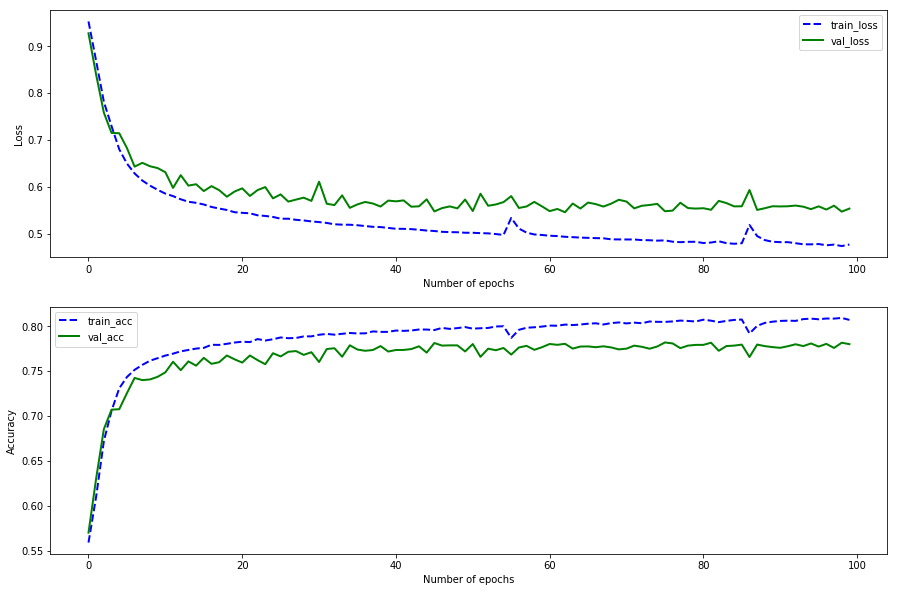

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
plt.legend()
# plt.ylim([.2,1.0])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [23]:
target_names = [mapping[str(i)] for i in range(3)]
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))

              precision    recall  f1-score   support

        down       0.69      0.70      0.69      9589
  stationary       0.79      0.79      0.79     19224
          up       0.71      0.69      0.70      9934

    accuracy                           0.74     38747
   macro avg       0.73      0.73      0.73     38747
weighted avg       0.74      0.74      0.74     38747

[[ 6742  2061  1036]
 [ 2025 15127  2023]
 [  822  2036  6875]]


In [24]:
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 74.18380975723267%
